In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Variables

y_variable = 'smoke'
datapoints_train = 8

In [3]:
def load_clean_dataset():
  dataset = pd.read_csv('./iot_telemetry_data.csv')
  print("Original dimension of the", y_variable, "column is", dataset[y_variable].shape)
  return dataset

dataset = load_clean_dataset()

Original dimension of the smoke column is (405184,)


In [4]:
def timestamp_to_date(dataset):
  dataset['ts']= pd.to_datetime(dataset['ts'], unit='s')          #Convert timestamp to date
  print('Dataset with replaced timstamp column looks like:')
  print(dataset[['ts',y_variable]])
  return dataset

timestamp_to_date(dataset)

Dataset with replaced timstamp column looks like:
                                  ts     smoke
0      2020-07-12 00:01:34.385974528  0.020411
1      2020-07-12 00:01:34.735567616  0.013275
2      2020-07-12 00:01:38.073572864  0.020475
3      2020-07-12 00:01:39.589145856  0.018628
4      2020-07-12 00:01:41.761234944  0.020448
...                              ...       ...
405179 2020-07-20 00:03:33.162014976  0.016437
405180 2020-07-20 00:03:33.576560640  0.023301
405181 2020-07-20 00:03:36.167959296  0.019076
405182 2020-07-20 00:03:36.979521536  0.016437
405183 2020-07-20 00:03:37.264312576  0.023400

[405184 rows x 2 columns]


,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 00:01:34.385974528,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,2020-07-12 00:01:34.735567616,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,2020-07-12 00:01:38.073572864,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,2020-07-12 00:01:39.589145856,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,2020-07-12 00:01:41.761234944,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,2020-07-20 00:03:33.162014976,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,2020-07-20 00:03:33.576560640,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,2020-07-20 00:03:36.167959296,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,2020-07-20 00:03:36.979521536,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


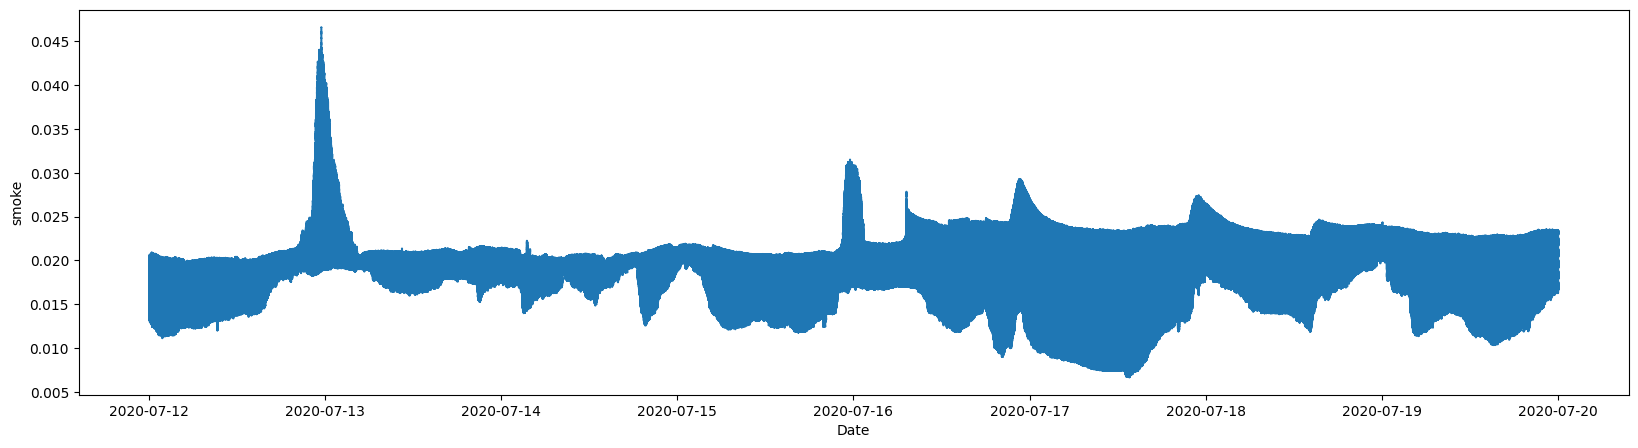

In [5]:
def plot(dataset):
  plt.figure(figsize=(20,5))
  plt.xlabel('Date')
  plt.ylabel(y_variable)
  plt.plot(dataset['ts'], dataset[y_variable], linestyle='dashed')
  plt.show()

plot(dataset)

In [6]:
def normalise(dataset):
  y_variable_mean = np.mean(dataset[y_variable])
  y_variable_sd = np.std(dataset[y_variable])
  dataset[y_variable] = (dataset[y_variable] - y_variable_mean) / y_variable_sd                 #Standardize values with 0 mean and 1 variance
  return dataset

In [7]:
def split_train_test(dataset):
  train, test = train_test_split(dataset[y_variable], test_size=0.1, shuffle=False)    #in-biult sklearn method to split data into train and test with shuffle = False
  test = test.reset_index()                                                            #reset index of test data
  test = test[y_variable]                                                              #remove additional index coloumn
  print('The shape of Training Data is: ', train.shape)
  print('The shape of Testing Data is: ', test.shape)
  print(test)
  return train, test

In [8]:
def prepare_data(data, type):																										#Prepare data as Time-series inputs v/s Next close price
	X, y = [],[]
	for i in range(len(data)):
		last_day = i + datapoints_train																														#Taking data of 7 previous days
		if last_day > len(data)-1:																									#For last value
			break
		prev_data, next_price = data[i:last_day], data[last_day]
		X.append(prev_data)																													#Create Input set
		y.append(next_price)																												#Create corresponding Output set
	if type == 'train':
		print('X_train shape is:', np.array(X).shape)
		print('y_train shape is:', np.array(y).shape)
	else:
		print("X_test shape is:", np.array(X).shape)
		print("y_test shape is:", np.array(y).shape)

	return np.array(X), np.array(y)																								#Numpy conversion for sequential model

In [9]:
def reshape(X):
  X = X.reshape((X.shape[0], X.shape[1], 1))                                    #reshape input to [Batch_size, Number_of_Timesteps, One_Timestep_at_a_time]
  return X

In [10]:
def plot_ypred(dataset, train_length, y_test, y_pred):
  plt.figure(figsize=(20, 5))
  plt.xlabel('Date')
  plt.ylabel(y_variable)
  plt.plot(dataset['ts'][train_length+datapoints_train:], y_test, label='y_test', linestyle='dashed')
  plt.plot(dataset['ts'][train_length+datapoints_train:], y_pred, label='y_pred', linestyle='dashed' )
  plt.legend()
  plt.show()

In [11]:
def loss_metrics(actual, pred):
  rmse = np.sqrt(mean_squared_error(actual, pred))
  mae = mean_absolute_error(actual, pred)
  r2 = r2_score(actual, pred)
  print("RMSE between y_pred and y is {}".format(round(rmse, 3)))
  print("Mean Absolute Error between y_pred and y is {}".format(round(mae, 3)))
  print("R2_Score between y_pred and y is {}".format(round(r2, 3)))

Original dimension of the smoke column is (405184,)
Dataset with replaced timstamp column looks like:
                                  ts     smoke
0      2020-07-12 00:01:34.385974528  0.020411
1      2020-07-12 00:01:34.735567616  0.013275
2      2020-07-12 00:01:38.073572864  0.020475
3      2020-07-12 00:01:39.589145856  0.018628
4      2020-07-12 00:01:41.761234944  0.020448
...                              ...       ...
405179 2020-07-20 00:03:33.162014976  0.016437
405180 2020-07-20 00:03:33.576560640  0.023301
405181 2020-07-20 00:03:36.167959296  0.019076
405182 2020-07-20 00:03:36.979521536  0.016437
405183 2020-07-20 00:03:37.264312576  0.023400

[405184 rows x 2 columns]


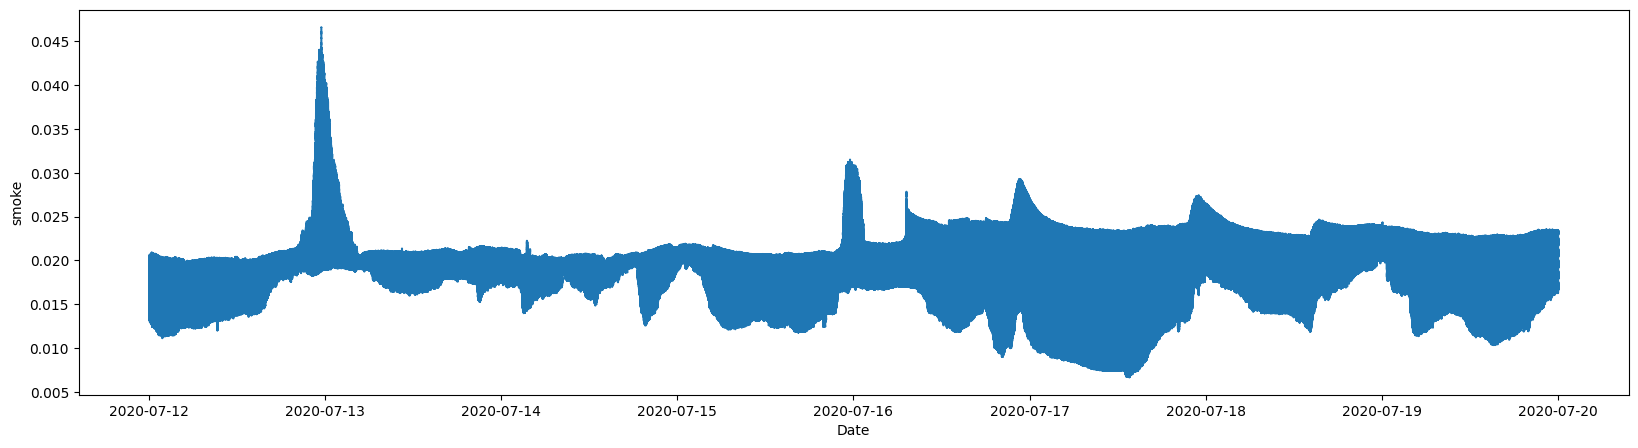

The shape of Training Data is:  (364665,)
The shape of Testing Data is:  (40519,)
0       -0.203192
1       -1.884712
2        0.937727
3       -0.204768
4       -1.884712
           ...   
40514   -0.691821
40515    0.988081
40516   -0.045924
40517   -0.691821
40518    1.012202
Name: smoke, Length: 40519, dtype: float64
X_train shape is: (364657, 8)
y_train shape is: (364657,)
X_test shape is: (40511, 8)
y_test shape is: (40511,)
Epoch 1/3
11396/11396 [==============================] - 44s 4ms/step - loss: 0.5779
Epoch 2/3
11396/11396 [==============================] - 45s 4ms/step - loss: 0.5499
Epoch 3/3
1266/1266 [==============================] - 3s 2ms/step - loss: 0.6591
RMSE on test set is 0.812
1266/1266 [==============================] - 2s 2ms/step
[-1.88471216  0.96138371 -1.86697319 ... -0.04592439 -0.69182106
  1.0122022 ] [[-0.78348553]
 [ 0.7602477 ]
 [-0.5382906 ]
 ...
 [-0.03179913]
 [ 0.35854548]
 [ 0.86994964]]


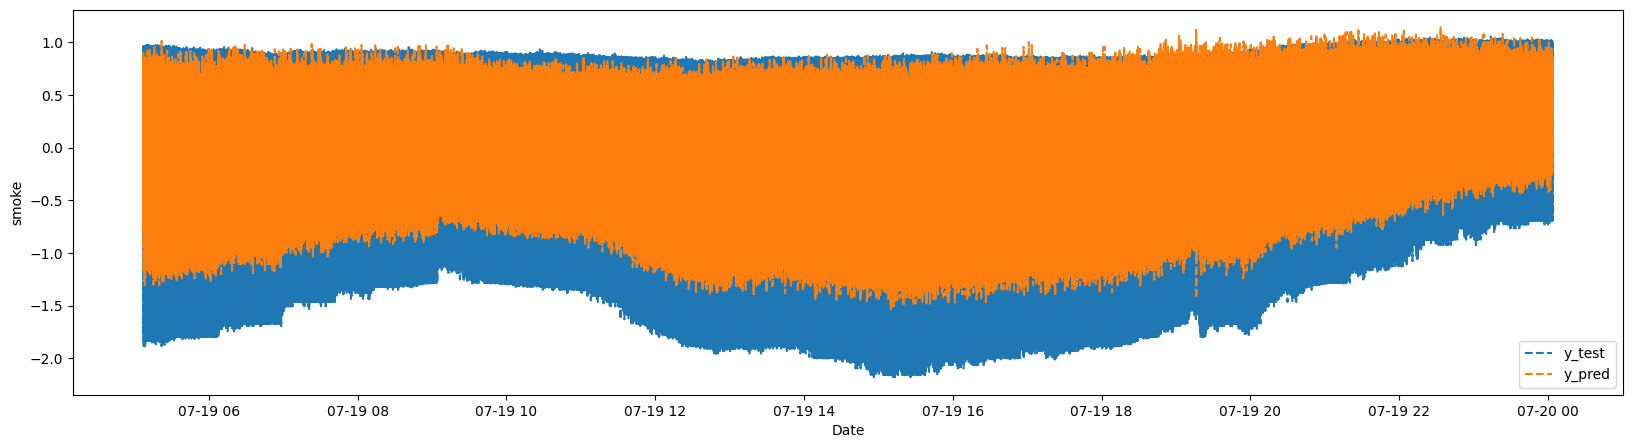

RMSE between y_pred and y is 0.812
Mean Absolute Error between y_pred and y is 0.658
R2_Score between y_pred and y is 0.399


In [12]:
#Load, Preprocess, Split, Reshape
dataset = load_clean_dataset()
dataset = timestamp_to_date(dataset)
plot(dataset)
dataset = normalise(dataset)
train, test = split_train_test(dataset)
X_train, y_train = prepare_data(train, 'train')
X_test, y_test = prepare_data(test, 'test')
X_train = reshape(X_train)
X_test = reshape(X_test)

#Design LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(datapoints_train, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=3, verbose=1)

#Evaluate Model
mse = model.evaluate(X_test, y_test)
rmse_test = np.sqrt(mse)
print("RMSE on test set is {}".format(round(rmse_test, 3)))

#Predict y_pred, Plot results and Evaluate Loss metrics:
y_pred = model.predict(X_test)
print(y_test, y_pred)
plot_ypred(dataset, len(train), y_test, y_pred)
loss_metrics(y_test, y_pred)